<a href="https://colab.research.google.com/github/kerul31/Google_Colab_Modules/blob/main/SAS_birds_assigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install saspy

In [32]:
import saspy
saspy

<module 'saspy' from '/usr/local/lib/python3.7/dist-packages/saspy/__init__.py'>

In [33]:
sas = saspy.SASsession(java='/usr/bin/java', iomhost=['odaws01-usw2.oda.sas.com','odaws02-usw2.oda.sas.com','odaws03-usw2.oda.sas.com','odaws04-usw2.oda.sas.com'], iomport=8591, encoding='utf-8')

Using SAS Config named: default
Please enter the IOM user id: kerulsuthar@gmail.com
Please enter the password for IOM user : ··········
SAS Connection established. Subprocess id is 1297



## Exploring the bird dataset in SAS
It contains measurements on breeding pairs of land-bird species collected from 16 islands
around Britain over the course of several decades. For each species, the data set contains
an average time of extinction on those islands where it appeared, the average number of
nesting pairs, the size of the species (large or small), and the migratory status of the species
(migrant or resident). It is expected that species with larger numbers of nesting pairs will
tend to be remain longer before becoming extinct.

In [34]:
sas.submitLST("""
filename myfile url 'http://www.auburn.edu/~zengpen/teaching/STAT-7000/datasets/birds.csv';
proc import out = birds
datafile = myfile dbms = csv replace;
run;
""")

In [35]:
sas.submitLST("""
proc print data = birds; run;
""")

Obs,SPECIES,TIME,PAIRS,SIZE,STATUS
1,Sparrowhawk,3.03,1,L,R
2,Buzzard,5.46,2,L,R
3,Kestrel,4.1,1.21,L,R
4,Peregrine,1.68,1.13,L,R
5,Grey_partridge,8.85,5.17,L,R
6,Quail,1.49,1,L,M
7,Red-legged_partridge,7.69,2.75,L,R
8,Pheasant,3.85,5.63,L,R
9,Water_rail,16.67,3,L,R
10,Corncrake,4.22,4.67,L,M


## This is a scatter plot showing exploratory data analysis. The scatter plot shows Time vs Pairs and the data points are grouped by the size of birds.

It may be safe to assume that birds that are small in size in general are extinct earlier than the birds that are relatively larger in size




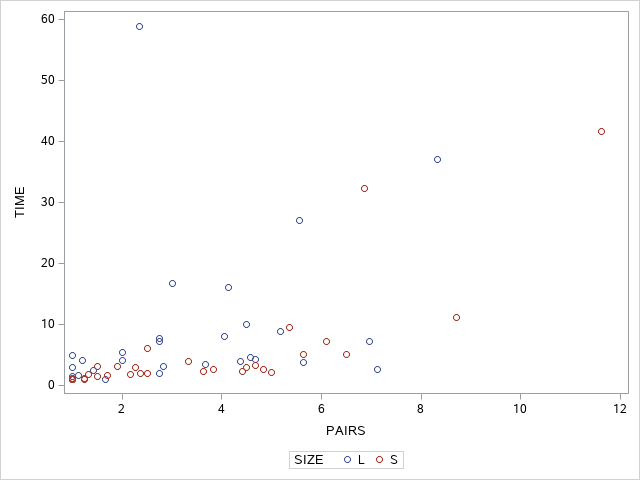

In [36]:
sas.submitLST("""
proc sgplot data = birds;
scatter y =time x = pairs / group = size;
run;
""")


### Similar behavior can be investigated for birds based on their migration status. So we plot a scatter plot for the extinction time vs the number of nesting pairs and group them by their migration status


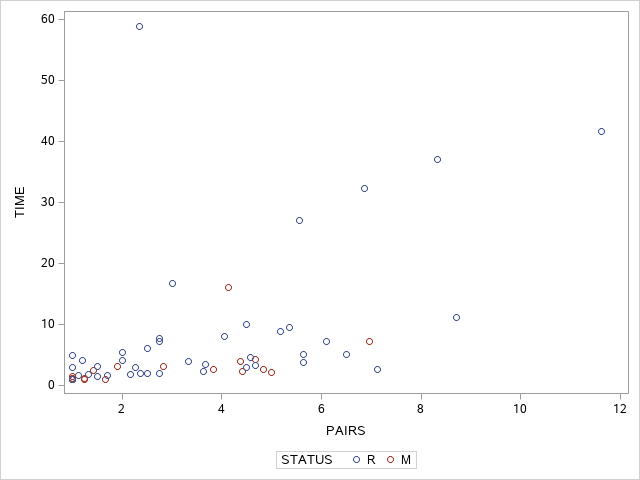

In [37]:
sas.submitLST("""

proc sgplot data = birds;
scatter y =time x = pairs / group = status;
run;

""")

It is seen from the scatter plot above that the resident bird species are able to survive better than the migrated birds. Even with the increase in number of nesting pairs, there is a slight increase in the time of extinction, but overall the resident birds take higher time to become extinct than the migrated birds.


Box plots can also be a great source to explore the data. A box plot displays the mean, quartiles, and minimum and maximum observations of the group.


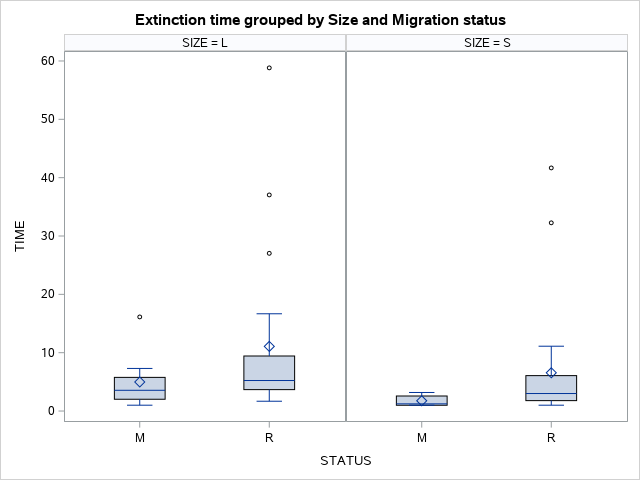

In [38]:
sas.submitLST("""

proc sgpanel data=birds;
panelby size / rows=1 columns=2 ;
vbox time / category= status;
title 'Extinction time grouped by Size and Migration status';
run;

""")


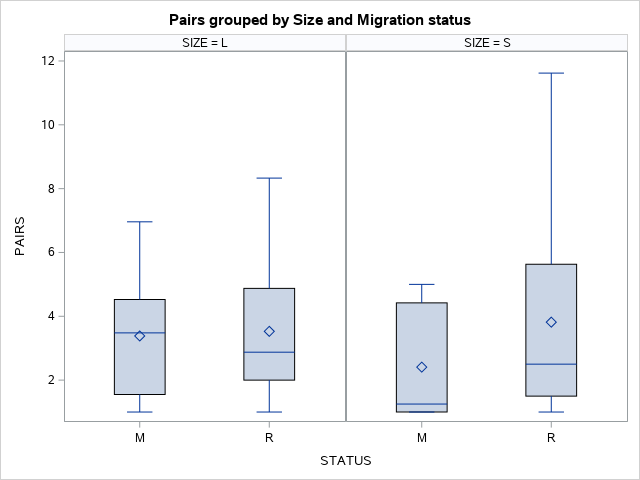

In [39]:
sas.submitLST("""

proc sgpanel data=birds;
panelby size / rows=1 columns=2 ;
vbox pairs / category= status;
title 'Pairs grouped by Size and Migration status';
run;

""")

The figure above shows that no matter what the migration status, on an average, birds with larger size have higher number of nesting pairs in comparison to the birds with smaller size.



#### Now we further investigate the same plots with data transformation. We take the natural log of the variable of interest i.e. The time of extinction.

In [40]:
sas.submitLST("""
data h1a;
set birds;
TIME_log = log(time);
if size = 'L' then size_bin = 1; else size_bin = 0;
if status = 'M' then status_bin = 1; else status_bin = 0;
px2 = pairs * size_bin; px3 = pairs * status_bin; x2x3 = size_bin * status_bin;
px2x3 = pairs * size_bin * status_bin;
proc print data = h1a;
run;

""")

Obs,SPECIES,TIME,PAIRS,SIZE,STATUS,TIME_log,size_bin,status_bin,px2,px3,x2x3,px2x3
1,Sparrowhawk,3.03,1,L,R,1.10856,1,0,1.00,0.00,0,0.00
2,Buzzard,5.46,2,L,R,1.69745,1,0,2.00,0.00,0,0.00
3,Kestrel,4.1,1.21,L,R,1.41099,1,0,1.21,0.00,0,0.00
4,Peregrine,1.68,1.13,L,R,0.51879,1,0,1.13,0.00,0,0.00
5,Grey_partridge,8.85,5.17,L,R,2.18042,1,0,5.17,0.00,0,0.00
6,Quail,1.49,1,L,M,0.39878,1,1,1.00,1.00,1,1.00
7,Red-legged_partridge,7.69,2.75,L,R,2.03992,1,0,2.75,0.00,0,0.00
8,Pheasant,3.85,5.63,L,R,1.34807,1,0,5.63,0.00,0,0.00
9,Water_rail,16.67,3,L,R,2.81361,1,0,3.00,0.00,0,0.00
10,Corncrake,4.22,4.67,L,M,1.43984,1,1,4.67,4.67,1,4.67


### Tranformation of variables 

Here we have applied tranformations to categorical variables. As seen 
above, The categorical variable size has been transformed to a binary dummy variable and similar approach has been used for the migration status of residents.

Instead of using the extinction time, we have tranformed it using natural log to see the effect of variable transformation on the modeling.
Lets plot a scatter plot matrix after the transformations to understand the data better.

A robust way to analyze the interaction and relationship between variables is the correlation matrix. Positive correlation defines how when one variables increases in magnitude, the other variable also increases or changes in similar direction. A negative correlation means when a variables increases in magnitude, the other variables decreses. 

The magnitude of correalation lies between -1 and +1. +1 means strongest positive relationship. -1 means strongest negative correlation. A correlation of 0 defines no linear relationship at all between two variables.


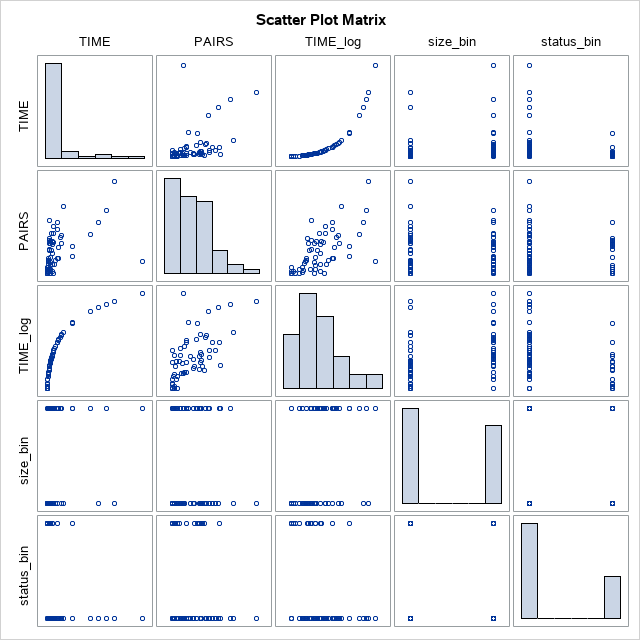

In [41]:
sas.submitLST("""
proc corr data=h1a plots=matrix(histogram);
run;
""")


As seen in the scatter plot above and the correlation coefficients between the original variables and the transformed variables, the time of extinction is positively correlated to pairs with a correlation coefficient of 0.5 and is positively significant. 

Also, we see that other variables do not have a strong correlation with the time of extinction of birds. 

When the tranformation is used on variables,i.e. the log of time of extinction, the correlation improves, which shows exponential relationship suits better between the nested pairs and the time of extinction of birds.


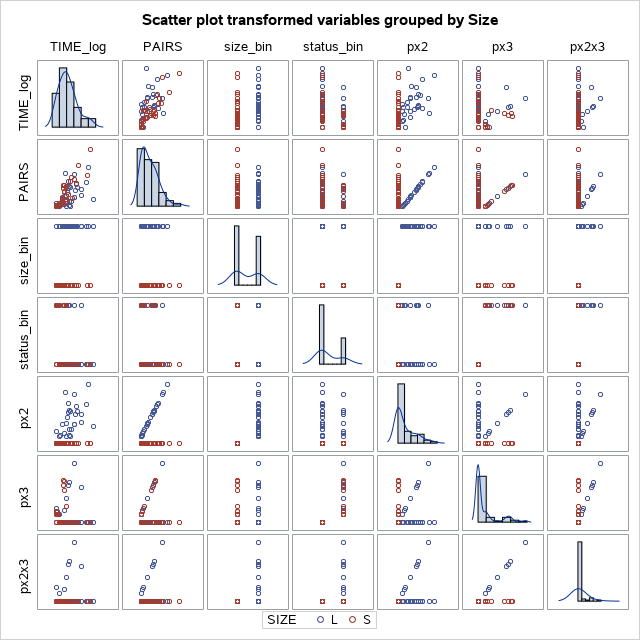

In [49]:
sas.submitLST("""
proc sgscatter data=h1a; 
matrix time_log pairs size_bin status_bin px2 px3 px2x3 /group=Size diagonal=(histogram kernel);
title 'Scatter plot transformed variables grouped by Size ';
run;
""")


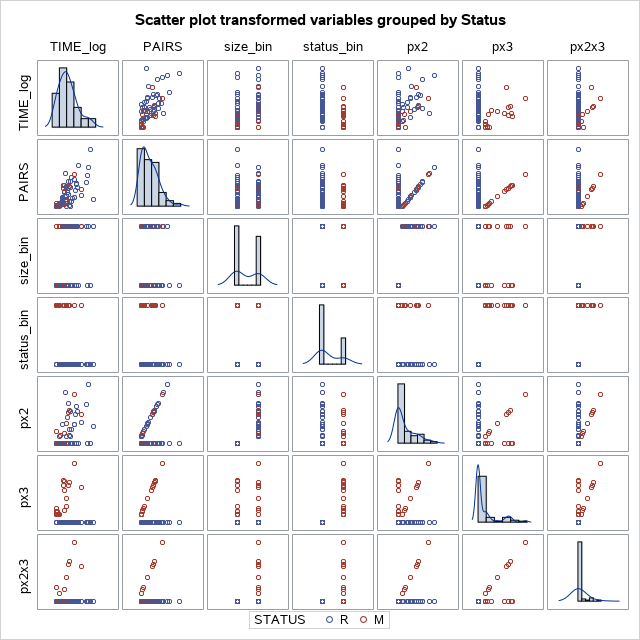

In [50]:
sas.submitLST("""
proc sgscatter data=h1a; 
matrix time_log pairs size_bin status_bin px2 px3 px2x3 /group=Status diagonal=(histogram kernel);
title 'Scatter plot transformed variables grouped by Status ';
run;
""")

### Now lets look into linear regression models with original variables and transformed variables trying to predict the Time of extinction for bird speices.



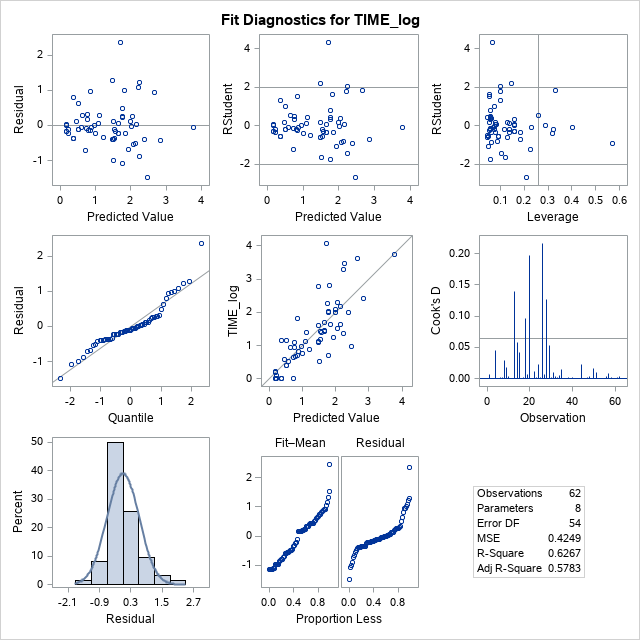
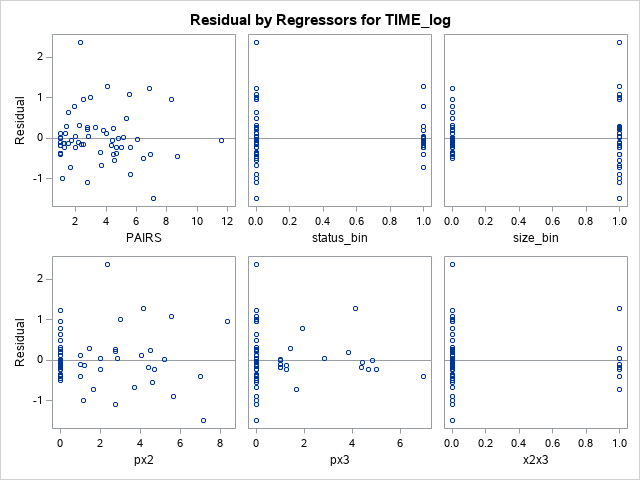
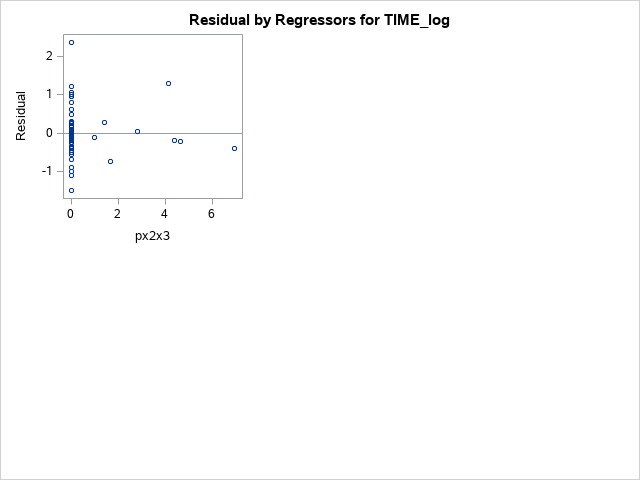

In [44]:
sas.submitLST("""
proc reg data = h1a;
model time_log= pairs status_bin size_bin px2 px3 x2x3 px2x3 / clb;
test px2 = 0, px3 = 0, x2x3 = 0, px2x3 = 0;
run;
""")


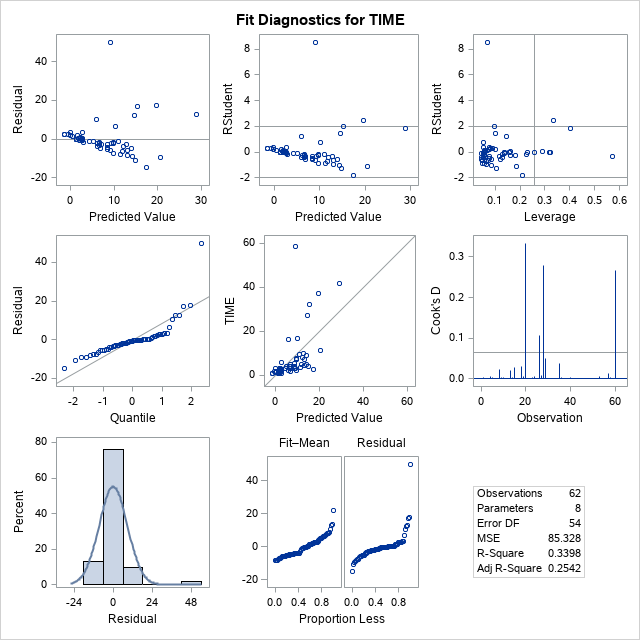
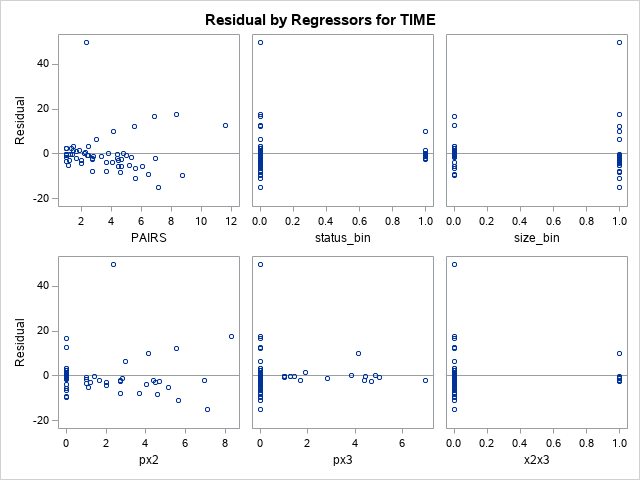
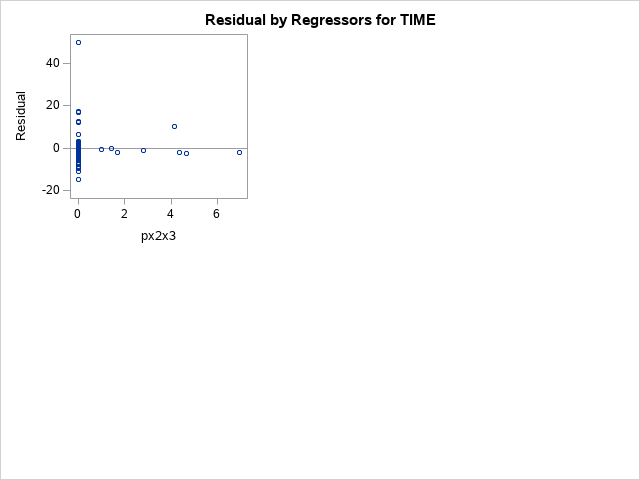

In [45]:
sas.submitLST("""
proc reg data = h1a;
model time= pairs status_bin size_bin px2 px3 x2x3 px2x3 / clb;
test px2 = 0, px3 = 0, x2x3 = 0, px2x3 = 0;
run;
""")

We can see that predicting the time_log instead of time yields a better R2 than prediciting time which shows the importance of variable transformation


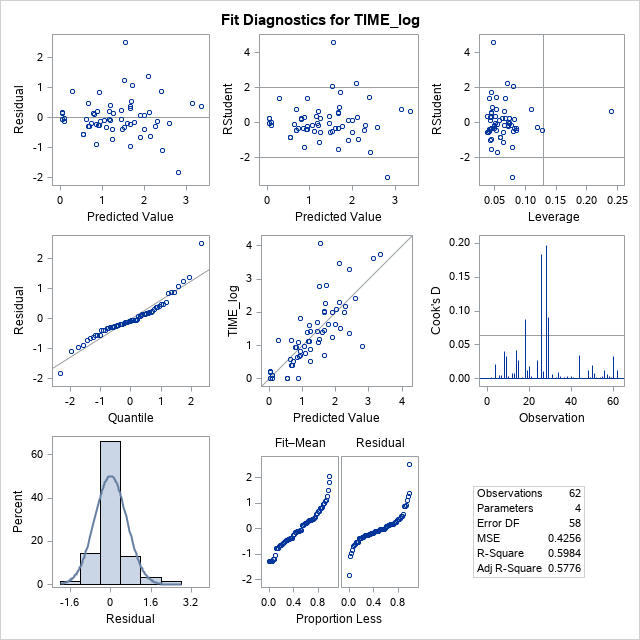
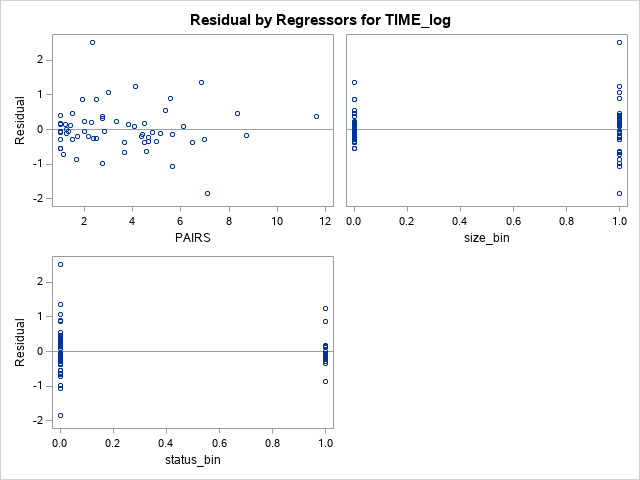

In [57]:
sas.submitLST("""
proc reg data = h1a;
model time_log= pairs size_bin status_bin  / clb;
test px2 = 0, px3 = 0, x2x3 = 0, px2x3 = 0;
run;
""")